**1. Connecting Drive**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Dataset Paths:**

In [15]:
train_dir = "/content/drive/MyDrive/AI&ML-Level6/Week - 5/Week - 5 - Image Classification with CNN/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI&ML-Level6/Week - 5/Week - 5 - Image Classification with CNN/FruitinAmazon/FruitinAmazon/test"

**Task 1: Improve the Model from Worksheet 5**

Step 1: Data Understanding and Preprocessing

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']

No corrupted images found.

Class Distribution: 
acai: 15
cupuacu: 15
graviola: 15
guarana: 15
pupunha: 15
tucuma: 15


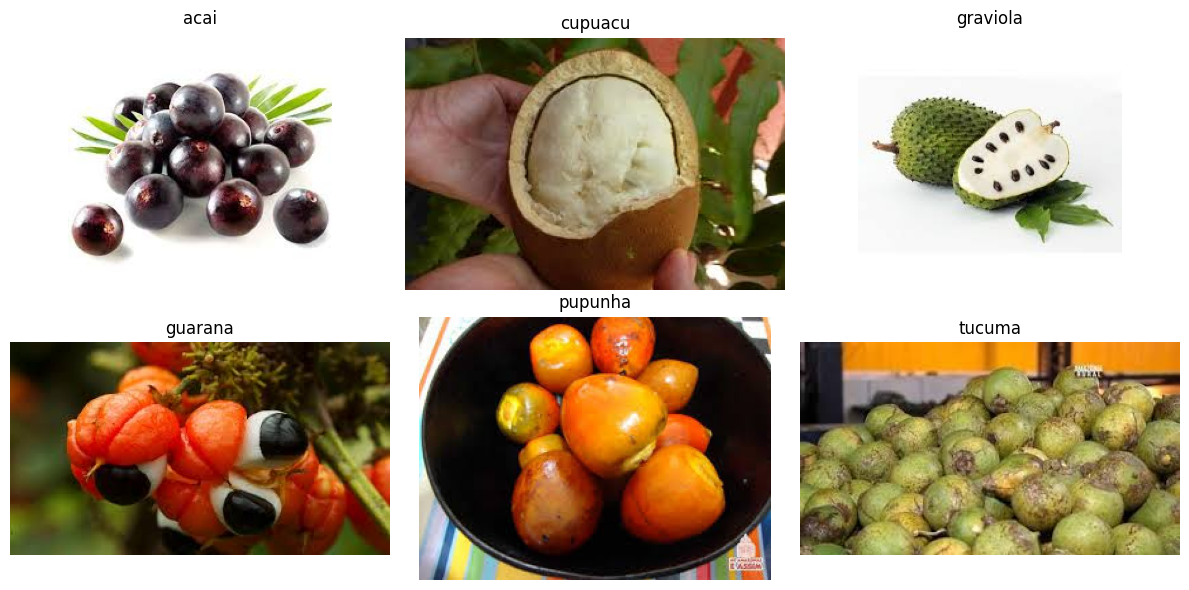

In [16]:
import os
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import random

# Define dataset paths
train_dir = "/content/drive/MyDrive/AI&ML-Level6/Week - 5/Week - 5 - Image Classification with CNN/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI&ML-Level6/Week - 5/Week - 5 - Image Classification with CNN/FruitinAmazon/FruitinAmazon/test"

# Get class names from train directory
class_names = sorted(os.listdir(train_dir))
if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")

# Check for corrupted images in train directory
corrupted_images = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

if corrupted_images:
    print("\nCorrupted Images Found: ")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")

# Check class balance
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)
print("\nClass Distribution: ")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")
print("=" * 45)

# Visualize random images
selected_images, selected_labels = [], []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        selected_img = os.path.join(class_path, random.choice(images))
        selected_images.append(selected_img)
        selected_labels.append(class_name)

# Plot random images
cols = (len(selected_images) + 1) // 2
fig, axes = plt.subplots(2, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img = plt.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

**Step 2: Data Generation and Augmentation**

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


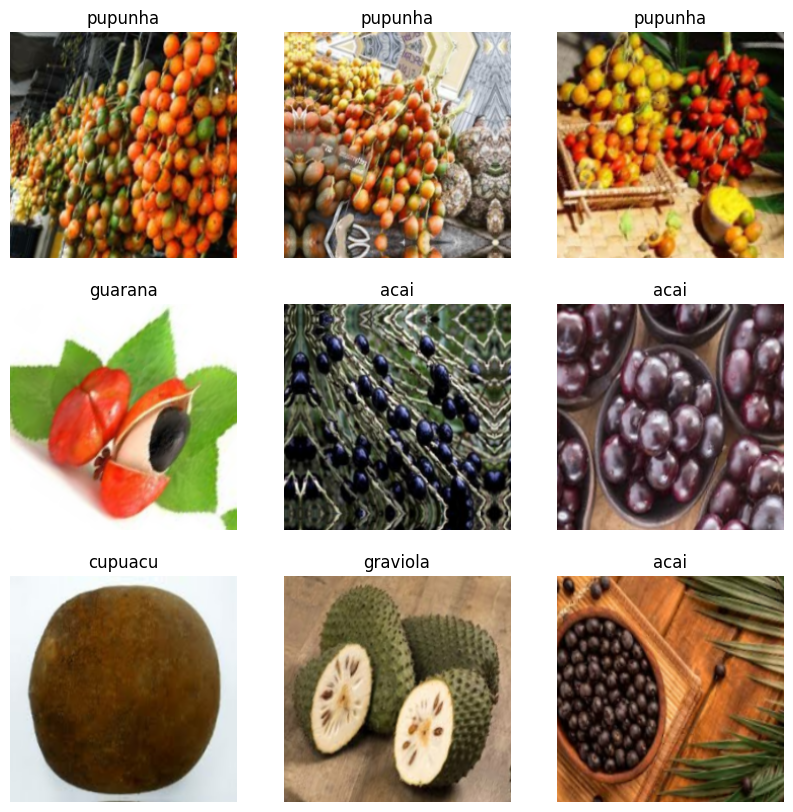

In [17]:
import tensorflow as tf
from tensorflow.keras import layers

# Define image size and batch size
image_size = (224, 224)  # Matches VGG16 input size
batch_size = 32

# Load train dataset and split into train/validation
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

# Define data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply augmentation and rescaling
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = augmented_train_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))
val_ds = val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

# Visualize augmented images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

Step 3: Build and Train the Enhanced Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 51,480,006 (196.38 MB)

 Trainable params: 51,478,534 (196.38 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.1832 - loss: 3.0144 - val_accuracy: 0.2222 - val_loss: 1.7726
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.5768 - loss: 1.6180 - val_accuracy: 0.2222 - val_loss: 1.7975
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.6515 - loss: 1.0613 - val_accuracy: 0.2222 - val_loss: 1.8736
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.6523 - loss: 0.9527 - val_accuracy: 0.2222 - val_loss: 2.0637
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.7313 - loss: 0.7199 - val_accuracy: 0.2222 - val_loss: 2.2677
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.6988 - loss: 0.6796 - val_accuracy: 0.2222 - val_loss: 2.4926
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.6940 - loss: 0.8836 - val_accuracy: 0.2222 - val_loss: 2.7471
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.7530 - loss: 0.5451 - val_accuracy: 0.2222 - val_loss: 2.9241
Epoch 9/

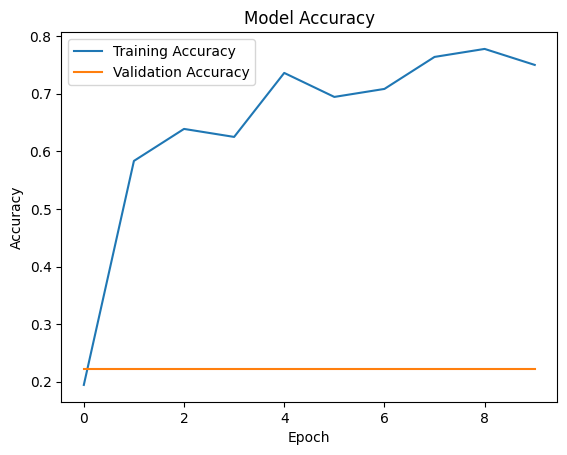

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout

# Define the model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),  # Already applied, but included for consistency
    # Convolutional Block 1
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Convolutional Block 2
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Convolutional Block 3
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    # Flatten and Dense Layers
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Number of classes dynamically set
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

# Evaluate on validation set
test_loss, test_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {test_acc:.4f}")

# Plot training behavior
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Step 4: Analyze Results

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 154,437,076 (589.13 MB)

 Trainable params: 51,478,534 (196.38 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 102,957,070 (392.75 MB)

**Task 2: Image Classification via Fine-Tuning with VGG16**

Step 1: Reuse Dataset from Task 1

In [20]:
# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=False  # Keep order for evaluation
)
test_ds = test_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

Found 30 files belonging to 6 classes.


Step 2: Load the Pre-trained VGG16 Model

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load VGG16 pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Step 3: Freeze the Base Model Layers

In [22]:
for layer in base_model.layers:
    layer.trainable = False

Step 4: Add Custom Layers

In [23]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(len(class_names), activation='softmax')(x)  # Dynamic number of classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

Step 5: Compile and Train the Model

In [24]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 59s 19s/step - accuracy: 0.0916 - loss: 1.8301 - val_accuracy: 0.0556 - val_loss: 1.9214
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 17s/step - accuracy: 0.3655 - loss: 1.5266 - val_accuracy: 0.3333 - val_loss: 1.7130
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 17s/step - accuracy: 0.6936 - loss: 1.3277 - val_accuracy: 0.5000 - val_loss: 1.6086
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 18s/step - accuracy: 0.7561 - loss: 1.1641 - val_accuracy: 0.3333 - val_loss: 1.6460
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 18s/step - accuracy: 0.7478 - loss: 1.0258 - val_accuracy: 0.3889 - val_loss: 1.7080
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 18s/step - accuracy: 0.7530 - loss: 0.9535 - val_accuracy: 0.2778 - val_loss: 1.7003
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 56s 17s/step - accuracy: 0.7600 - loss: 0.8751 - val_accuracy: 0.3333 - val_loss: 1.6277
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 66s 22s/step - accuracy: 0.8229 - loss: 0.7776 - val_accuracy: 0.3889 - val_loss: 1.5688


Step 6: Generate Inference Output and Classification Report

In [25]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions for test set
y_pred = []
y_true = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
              precision    recall  f1-score   support

        acai       0.50      0.40      0.44         5
     cupuacu       0.43      0.60      0.50         5
    graviola       1.00      0.60      0.75         5
     guarana       0.67      0.80      0.73         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.38      0.60      0.46         5

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.48        30
weighted avg       0.50      0.50      0.48        30

